# Plotting age distributions with respect to genotype groups

[u'age23', u'age24', u'age33', u'age34', u'age44']
age24 W:0.9539 p:0.0769 44 subjects between 45 and 71


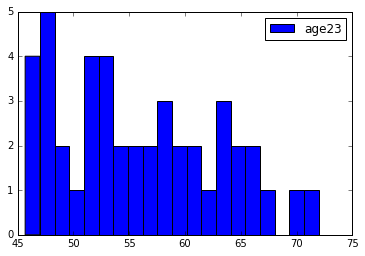

In [10]:
import pandas as pd
data = pd.read_excel('/home/grg/spm/designmat/fullmatrix.xls')
from matplotlib import pyplot as plt
%matplotlib inline
ages = [e for e in data.columns if 'age' in e and not 'sq' in e]
print ages
from scipy import stats
data2 = {}
for each in ages[1:2]:
    x = [int(i)/365.25 for i in data[each].tolist() if i>0]
    data2[each] = x
    plt.hist(x, bins=20)
    print each, 'W:%.4f p:%.4f'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(ages)
plt.show()

For two of the 5 groups, the Shapiro test p-value is lower than 1e-3, which means that the distributions of these two groups can't be considered as normal.

# Matching pairs using nearest neighbours

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler:
        scaler = StandardScaler()
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])    
    matched = non_treated_df.ix[indices]
    matched = non_treated_df.irow(matched.index)
    return matched

Loading data

In [119]:
df = pd.read_excel('/home/grg/spm/data/covariates.xls')
df = df[['subject','apo','age']]
groups = [df[df['apo']==i] for i in xrange(5)]
for i in xrange(5):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['subject']
    del groups[i]['apo']

Plotting data and see that the groups are now matching

/home/grg/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


(array([  5.,   3.,   3.,   4.,  10.,   4.,   5.,   5.,   0.,   4.,   3.,
          3.,   0.,   0.,   5.,   2.,   3.,   2.,   1.,   3.]),
 array([ 45.5578371 ,  46.66584531,  47.77385352,  48.88186174,
         49.98986995,  51.09787817,  52.20588638,  53.31389459,
         54.42190281,  55.52991102,  56.63791923,  57.74592745,
         58.85393566,  59.96194387,  61.06995209,  62.1779603 ,
         63.28596851,  64.39397673,  65.50198494,  66.60999316,  67.71800137]),
 <a list of 20 Patch objects>)

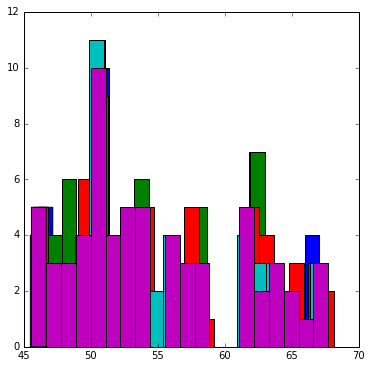

In [126]:
treated_df =  groups[4]
matched_df = [get_matching_pairs(treated_df, groups[i], False) for i in xrange(4)]

fig, ax = plt.subplots(figsize=(6,6))
for i in xrange(4):
    plt.hist(matched_df[i]['age'], bins=20)    
plt.hist(treated_df['age'], bins=20)

But normality is still not respected

In [130]:
for i in xrange(4):
    x = matched_df[i]['age'].tolist()
    print each, 'W:%.4f p:%.4f'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))
x = groups[4]['age'].tolist()
print each, 'W:%.4f p:%.4f'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

 10070 W:0.9224 p:0.0006 65 subjects between 46 and 67
10070 W:0.9255 p:0.0008 65 subjects between 45 and 67
10070 W:0.9316 p:0.0014 65 subjects between 45 and 68
10070 W:0.9315 p:0.0014 65 subjects between 45 and 67
10070 W:0.9306 p:0.0013 65 subjects between 45 and 67
